# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [4]:
# import libraries
import logging
import sys

import sqlite3
from sqlalchemy import create_engine
import pandas as pd

conn = sqlite3.connect('../data/DisasterResponse.db')

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# run a query
df = pd.read_sql('SELECT * FROM messages_categories', conn)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.columns

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [8]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df =  pd.read_sql_table('messages_categories', engine)
X = df.message.values
y = df.iloc[:,5:]
y.keys()

Index(['request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

### 2. Write a tokenization function to process your text data

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

def tokenize(text):
#     from nltk.corpus import stopwords
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word).lower().strip() 
        for word in words
        if word not in stopwords.words("english") and len(word) > 1
    ]
df.shape

[nltk_data] Downloading package punkt to /Users/slitayem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(26216, 40)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt 

In [78]:
pipeline = Pipeline([
  ('features', FeatureUnion([
    ('text', Pipeline([
        ('vect', CountVectorizer(
            tokenizer=tokenize,
            ngram_range=(1, 2),
            max_features=None)
        ),
        ('reduce_dim', TruncatedSVD()),
        ('tfidf', TfidfTransformer())
    ]))
    ], n_jobs=1)),
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        min_samples_split=10, criterion='entropy', n_estimators=120,
        max_features="auto")))
])

In [79]:
pipeline.get_params()

{'memory': None,
 'steps': [('features', FeatureUnion(n_jobs=1,
                transformer_list=[('text',
                                   Pipeline(memory=None,
                                            steps=[('vect',
                                                    CountVectorizer(analyzer='word',
                                                                    binary=False,
                                                                    decode_error='strict',
                                                                    dtype=<class 'numpy.int64'>,
                                                                    encoding='utf-8',
                                                                    input='content',
                                                                    lowercase=True,
                                                                    max_df=1.0,
                                                                    max_features=None,

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [81]:
%%time
pipeline.fit(X_train, Y_train)

CPU times: user 1min 24s, sys: 13.2 s, total: 1min 37s
Wall time: 1min 37s


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=1,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  lowercase=True,

In [82]:
pickle.dump(pipeline,  open("model.pkl", 'wb'))

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [17]:
y_pred_test = pipeline.predict(X_test)

In [32]:
def plot_classification_report(report, title):
#     report = classification_report(y_true, y_pred_class, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(4)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('tight')
    ax.set_title(title)
    ax.table(cellText=report_df.values,
             colLabels=report_df.columns,
             rowLabels=report_df.index,
             loc='center',
             bbox=[0.2, 0.2, 0.8, 0.8])
    fig.tight_layout()

    return fig

                        precision    recall  f1-score   support

               request       0.38      0.19      0.25      3595
                 offer       0.00      0.00      0.00        95
           aid_related       0.42      0.36      0.39      8665
          medical_help       0.11      0.00      0.00      1667
      medical_products       0.00      0.00      0.00      1057
     search_and_rescue       0.00      0.00      0.00       576
              security       0.00      0.00      0.00       359
              military       0.08      0.00      0.01       664
           child_alone       0.00      0.00      0.00         0
                 water       0.18      0.02      0.03      1333
                  food       0.22      0.06      0.09      2316
               shelter       0.10      0.01      0.01      1835
              clothing       0.00      0.00      0.00       321
                 money       0.00      0.00      0.00       472
        missing_people       0.00      

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


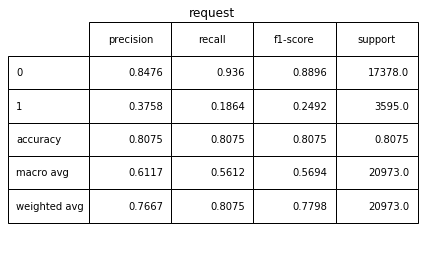

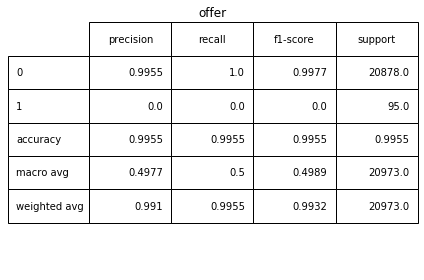

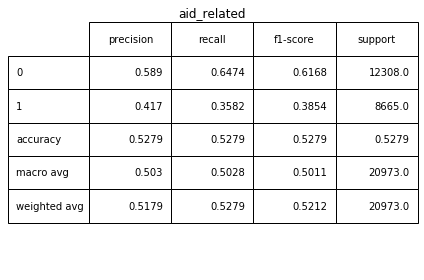

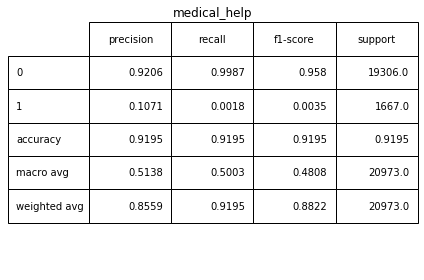

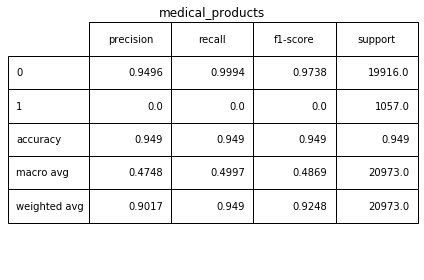

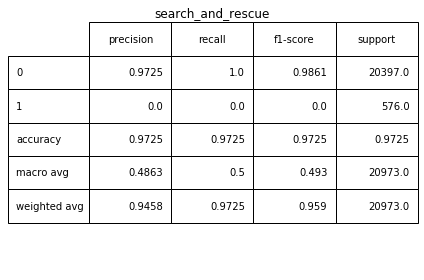

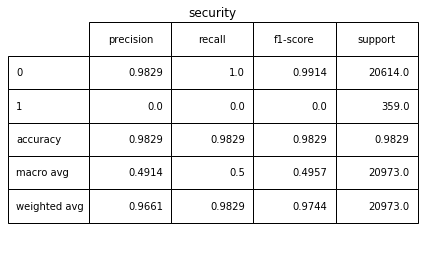

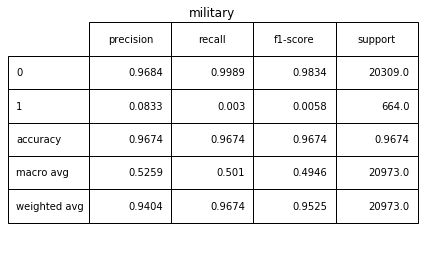

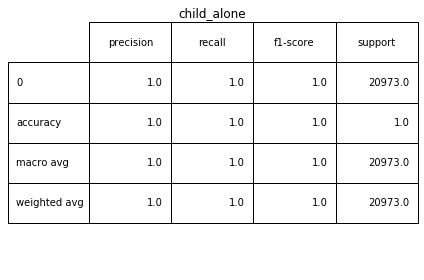

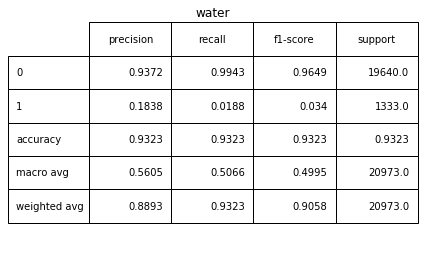

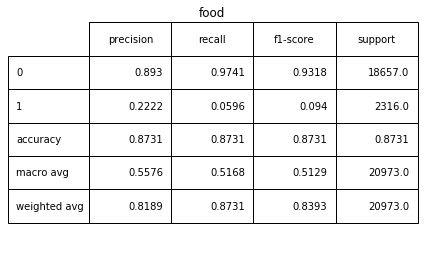

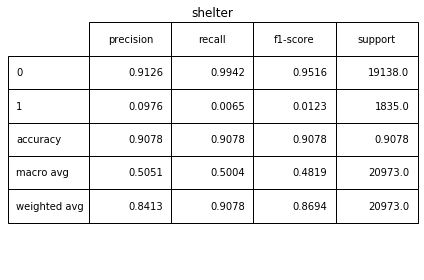

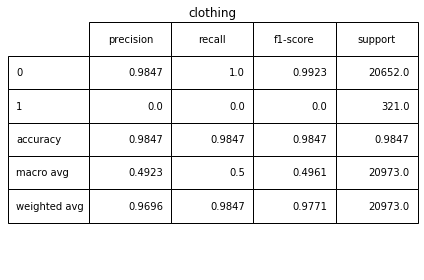

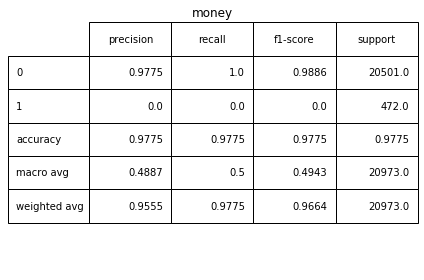

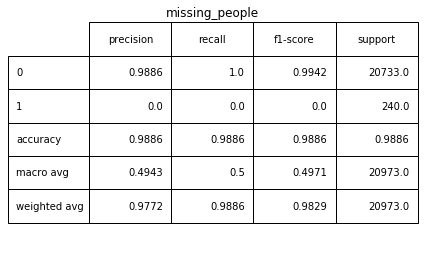

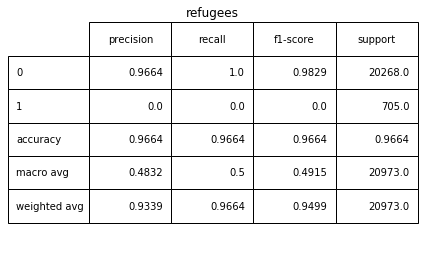

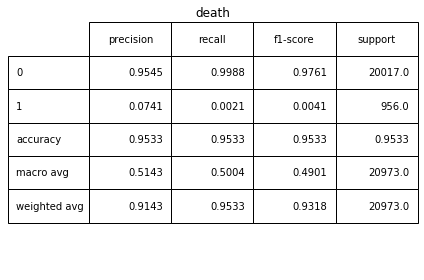

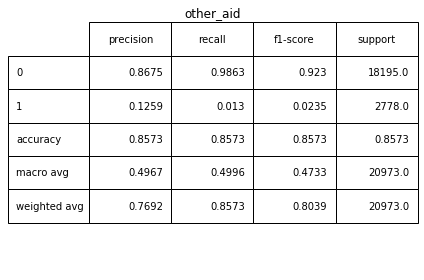

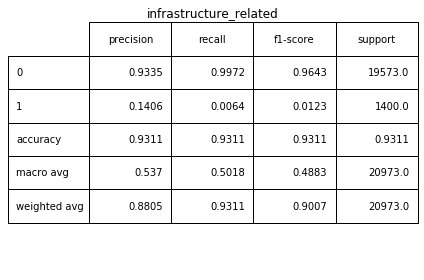

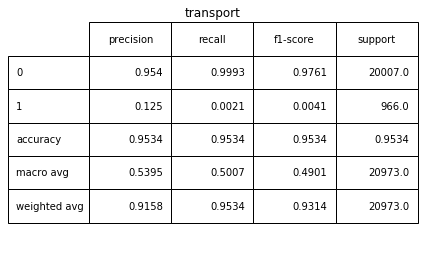

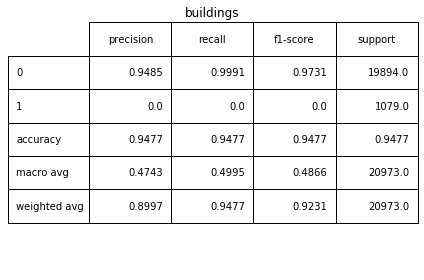

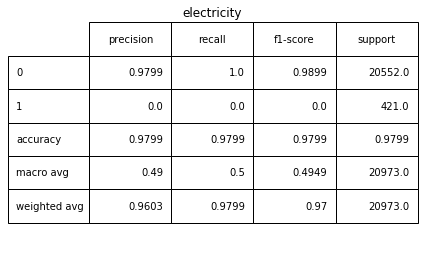

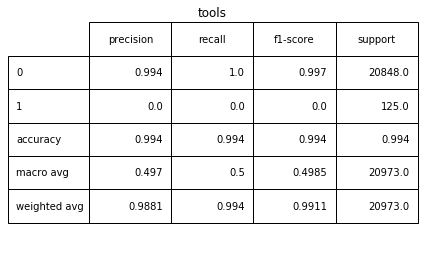

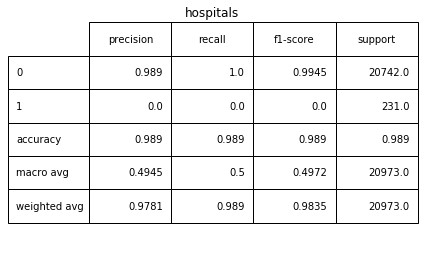

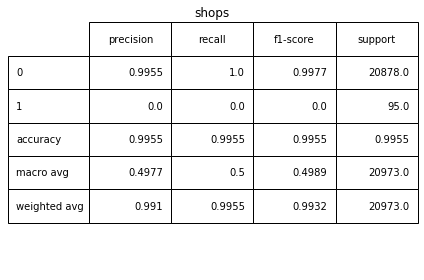

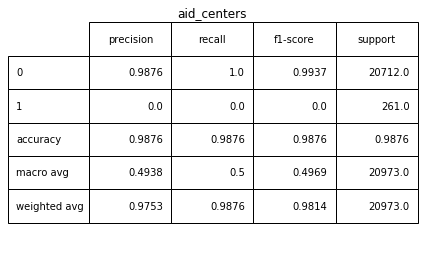

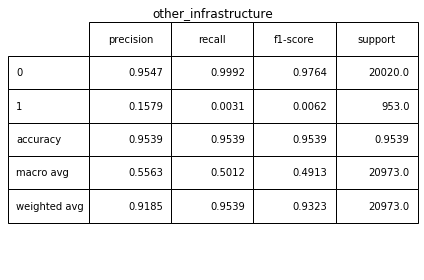

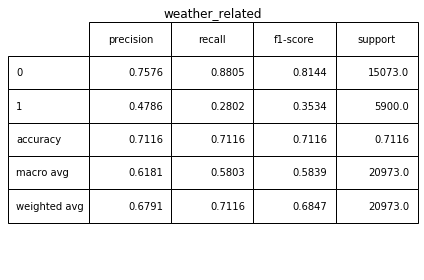

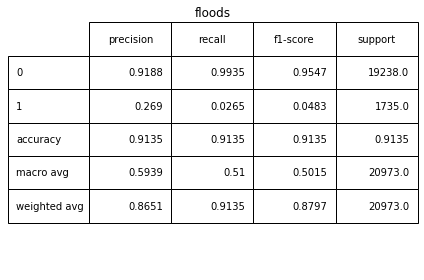

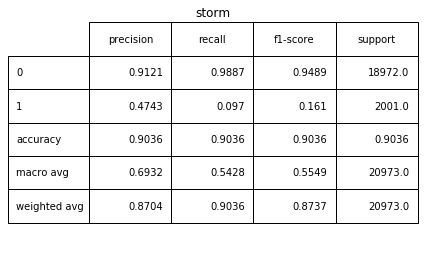

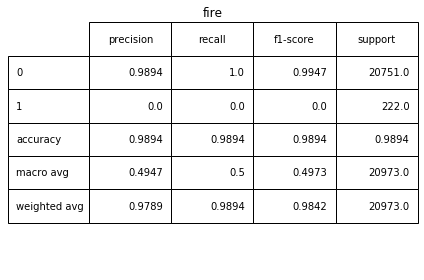

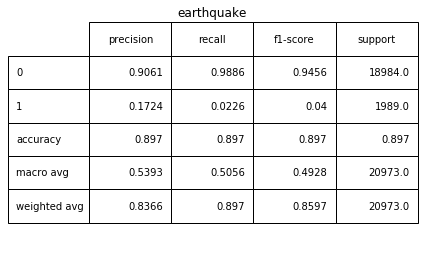

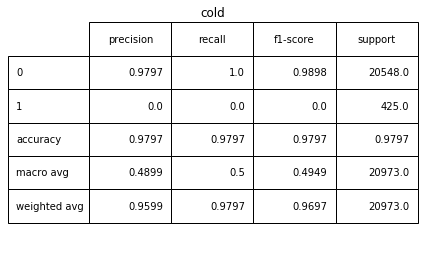

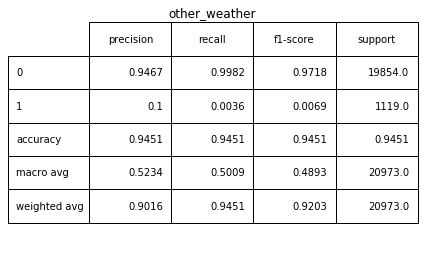

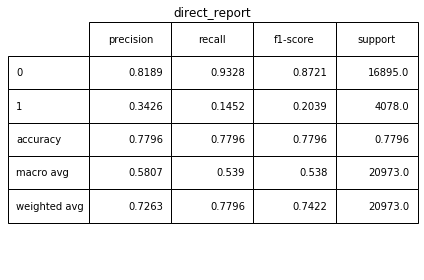

In [36]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_test, target_names=Y_test.columns))
for column_index, column in enumerate(Y_test.columns):
#     print("=================\n    {} \n=================".format(column))
#     print(classification_report(Y_test[column], y_pred_test[:, column_index]));
    report = classification_report(Y_test[column], y_pred_test[:, column_index], output_dict=True)
    plot_classification_report(report, column)

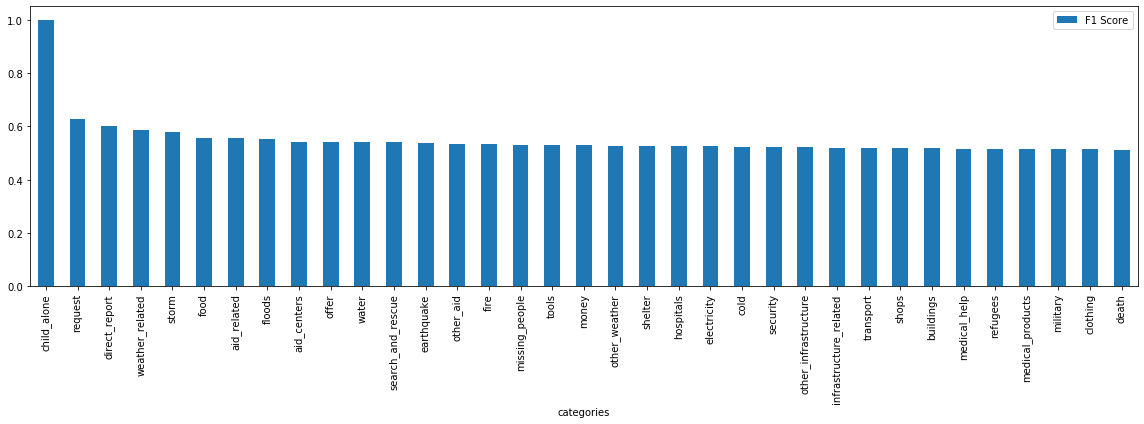

In [87]:
f1_scores = {}
for index, column in enumerate(Y_test.columns):
    report = classification_report(
        Y_test[column], y_pred_test[:, index],
        digits=4, output_dict=True)
    f1_scores[column] = report["macro avg"]["f1-score"]
f1_scores = dict(sorted(f1_scores.items(), key=lambda kv: kv[1], reverse=True))
fig_data = pd.DataFrame({"categories": list(f1_scores.keys()), "F1 Score": list(f1_scores.values())})
fig_data.plot.bar(figsize=(16, 6), x="categories", y="F1 Score")
plt.tight_layout()
plt.savefig("f1_scores_mlo_classifier.png")

In [85]:
# The same as accuracy_score
print("Classification score: {}".format(pipeline.score(X_test, Y_test)))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
Classification score: 0.208744576360082


Labels: [0 1]
Accuracy:
request                   0.753207
offer                     0.992037
aid_related               0.525581
medical_help              0.855815
medical_products          0.908406
search_and_rescue         0.948124
security                  0.960711
military                  0.935870
child_alone               1.000000
water                     0.886616
food                      0.820054
shelter                   0.844324
clothing                  0.972107
money                     0.951747
missing_people            0.975778
refugees                  0.935488
death                     0.914795
other_aid                 0.775807
infrastructure_related    0.887570
transport                 0.915987
buildings                 0.907643
electricity               0.964240
tools                     0.988604
hospitals                 0.979831
shops                     0.991465
aid_centers               0.979307
other_infrastructure      0.924284
weather_related           0.667

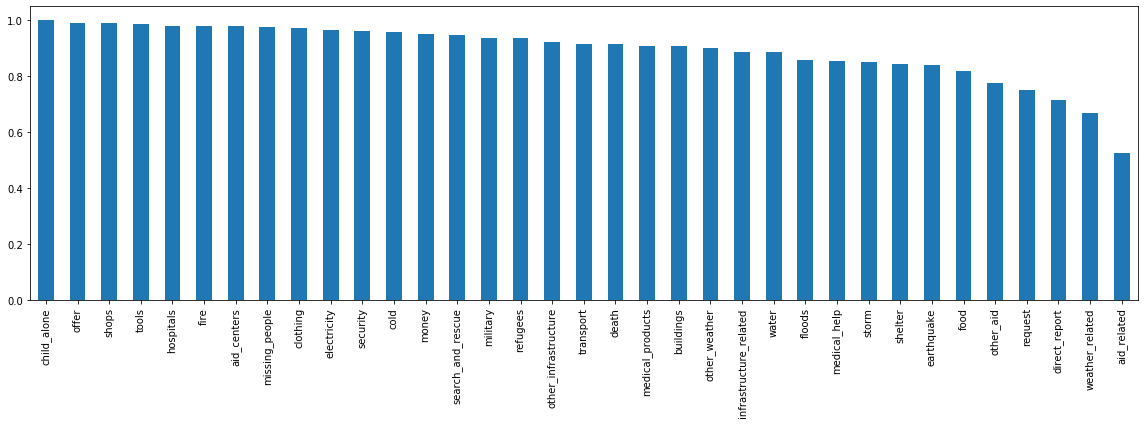

In [74]:
labels = np.unique(y_pred_test)
accuracy = (y_pred_test == Y_test).mean(axis=0)

print("Labels:", labels)
print("Accuracy:")
print(accuracy)

accuracy.sort_values(ascending=False, inplace=True)
accuracy.plot.bar(figsize=(16, 6))
plt.tight_layout()
plt.savefig('accuracy_mlo_classifier.png')

In [75]:
accuracy.mean()

0.8935542977024882

### 6. Improve your model
Use grid search to find better parameters. 

In [53]:
parameters = {
#     'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__text__vect__max_features': (None, 1000, 5000),
    'features__text__vect__ngram_range': [(1, 1), (1, 2)], # unigrams or bigrams
    'clf__estimator__max_depth': [None, 10, 20],
    'clf__estimator__min_samples_leaf': [4, 10],
#     'clf__estimator__n_estimators': [1, 10, 50],
#     'clf__estimator__criterion': ['gini', 'entropy'],
#     'clf__estimator__max_features': ['sqrt', 'log2'],
}
clf = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=-1, verbose=2)

In [ ]:
%%time
clf.fit(X_train, Y_train)

In [ ]:
clf.cv_results_.keys()

In [ ]:
for i in ['mean_test_score', 'std_test_score']:
        print(i," : ",clf.cv_results_[i])

In [ ]:
scores_df = pd.DataFrame(clf.cv_results_)
scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred_test = clf.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred_test, target_names=Y_test.columns))

In [ ]:
print('Test classification score: %.3f' % clf.score(X_test, Y_test))

In [ ]:
import numpy as np
labels = np.unique(y_pred_test)
accuracy = (y_pred_test == Y_test).mean(axis=0)

print("Labels:", labels)
print("Accuracy:")
print(accuracy)
print("\nBest Parameters:", clf.best_params_)
# {k: v for k, v in sorted(dict(accuracy).items(), key=lambda item: item[1], reverse=True)}
import matplotlib.pyplot as plt 
accuracy.sort_values(ascending=False, inplace=True)
accuracy.plot.bar(figsize=(16, 6))
# plt.show()
# plt.xticks(rotation=-45)
# plt.gcf().subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.savefig('accuracy_mlo_classifier_grd_sv.png')

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
pipeline_red_dim = Pipeline([
      ('features', FeatureUnion([

        ('text', Pipeline([
            ('vect', CountVectorizer(
                tokenizer=tokenize,
                stop_words=None)
            ),
            ('reduce_dim', TruncatedSVD()),
            ('tfidf', TfidfTransformer())
        ]))
    ], n_jobs = -1)),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])
parameters_red = {
#     'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
    'features__text__vect__max_features': (None, 1000, 5000),
    'features__text__vect__ngram_range': [(1, 1), (1, 2)], # unigrams or bigrams
    'features__text__reduce_dim__n_components': [1, 2, 10],  
    'clf__estimator__max_depth': [None, 10, 20],
    'clf__estimator__min_samples_leaf': [4, 10],
#     'clf__estimator__n_estimators': [1, 10, 50],
#     'clf__estimator__criterion': ['gini', 'entropy'],
#     'clf__estimator__max_features': ['sqrt', 'log2'],
}
clf_red_dim = GridSearchCV(estimator=pipeline_red_dim, param_grid=parameters_red,
                           n_jobs=-1, verbose=2)

In [ ]:
%%time
clf_red_dim.fit(X_train, Y_train)

In [ ]:
y_pred_test2 = clf_red_dim.predict(X_test)
print(classification_report(Y_test, y_pred_test2, target_names=Y_test.columns))

In [ ]:
print('Test classification score: %.3f' % clf_red_dim.score(X_test, Y_test))

In [ ]:
import numpy as np
labels = np.unique(y_pred_test)
accuracy = (y_pred_test2 == Y_test).mean(axis=0)

print("Labels:", labels)
print("Accuracy:")
print(accuracy)
print("\nBest Parameters:", clf.best_params_)

import matplotlib.pyplot as plt 
accuracy.sort_values(ascending=False, inplace=True)
accuracy.plot.bar(figsize=(16, 6))
plt.tight_layout()
plt.savefig('accuracy_mlo_classifier_dim_red.png')

### 9. Export your model as a pickle file

In [ ]:
# Save to file in the current working directory
import joblib
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    joblib.dump(clf, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    model = joblib.load(file)
    
# Calculate the accuracy score and predict target values
score = model.score(X_test, Y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = model.predict(X_test)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.